In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

output_base = '/content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split2'
train_dir = os.path.join(output_base, 'train')
test_dir = os.path.join(output_base, 'test')

# Define subfolder paths
folders = {
    "train_original": os.path.join(train_dir, 'original'),
    "train_generated": os.path.join(train_dir, 'generated'),
    "test_original": os.path.join(test_dir, 'original'),
    "test_generated": os.path.join(test_dir, 'generated'),
}

# Count images
def count_images(folder_path):
    return len([
        f for f in os.listdir(folder_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ])

# Print counts
for name, path in folders.items():
    try:
        count = count_images(path)
        print(f"{name}: {count} images")
    except Exception as e:
        print(f"Error reading {name}: {e}")


train_original: 7504 images
train_generated: 7431 images
test_original: 1141 images
test_generated: 895 images


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
output_base = '/content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split'
train_dir = os.path.join(output_base, 'train')
test_dir  = os.path.join(output_base, 'test')
IMG_SIZE = (224, 224)       #default input size is 224x224
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # <-- from VGG16 now
    validation_split=0.1,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 13497 images belonging to 2 classes.
Found 1499 images belonging to 2 classes.
Found 2072 images belonging to 2 classes.
Class indices: {'generated': 0, 'original': 1}


In [ ]:
#build vgg16 model
from tensorflow.keras.regularizers import l2
base_model = VGG16(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',

             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc'),
             F1Score(name='f1_score')],
)

In [ ]:
# 4. Callbacks
checkpoint_path = '/content/drive/MyDrive/vgg16_finetune(1aain)/checkpoint.h5'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
!pip install keras-tqdm

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator)//3,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)//3,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.5709 - auc: 0.5927 - f1_score: 0.4850 - loss: 4.1624 - precision: 0.6100 - recall: 0.4293
Epoch 1: val_auc improved from -inf to 0.00000, saving model to /content/drive/MyDrive/vgg16_finetune(1aain)/checkpoint.h5


140/140 ━━━━━━━━━━━━━━━━━━━━ 45s 318ms/step - accuracy: 0.5714 - auc: 0.5933 - f1_score: 0.4861 - loss: 4.1564 - precision: 0.6104 - recall: 0.4306 - val_accuracy: 0.8917 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 2.1733 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.7958 - auc: 0.8753 - f1_score: 0.8033 - loss: 2.3851 - precision: 0.7845 - recall: 0.8234
Epoch 2: val_auc did not improve from 0.00000
140/140 ━━━━━━━━━━━━━━━━━━━━ 38s 274ms/step - accuracy: 0.7960 - auc: 0.8755 - f1_score: 0.8035 - loss: 2.3842 - precision: 0.7847 - recall: 0.8235 - val_accuracy: 0.9563 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 1.9263 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.8705 - auc: 0.9398 - f1_score: 0.8717 - loss: 2.0207 - precision: 0.8598 - recall: 0.8841
Epoch 3: val_auc did not improve from 0.00000
140/140 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_auc did not improve from 0.00000
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9065 - auc: 0.9631 - f1_score: 0.9093 - loss: 1.7791 - precision: 0.8827 - recall: 0.9375 - val_accuracy: 0.9812 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 1.7145 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9195 - auc: 0.9660 - f1_score: 0.9210 - loss: 1.7638 - precision: 0.9158 - recall: 0.9265
Epoch 5: val_auc did not improve from 0.00000
140/140 ━━━━━━━━━━━━━━━━━━━━ 41s 290ms/step - accuracy: 0.9195 - auc: 0.9660 - f1_score: 0.9210 - loss: 1.7637 - precision: 0.9159 - recall: 0.9264 - val_accuracy: 0.9812 - val_auc: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_loss: 1.5616 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9191 - auc: 0.9658 - f1_score: 0.9192 - loss: 1.6347 - precision: 0.9179 - recall: 0.9208
Epoch 6: 

65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 643ms/step - accuracy: 0.8986 - auc: 0.5515 - f1_score: 0.5045 - loss: 1.1801 - precision: 0.4615 - recall: 0.5747
['loss', 'compile_metrics']

Test Results:
→ loss: 0.8502
→ accuracy: 0.953
→ precision: 0.927
→ recall: 0.994
→ AUC: 0.956
→ F1‑score: 0.959
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 488ms/step


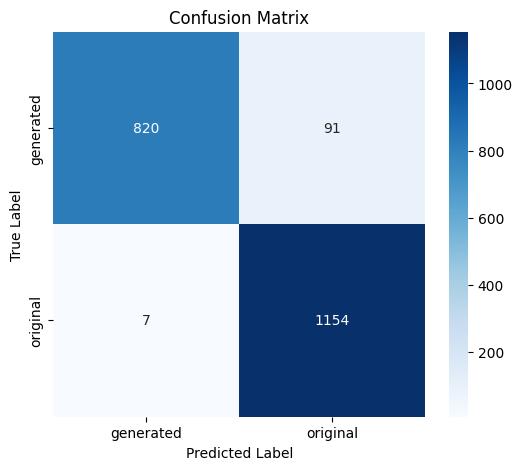


Classification Report:
              precision    recall  f1-score   support

   generated       0.99      0.90      0.94       911
    original       0.93      0.99      0.96      1161

    accuracy                           0.95      2072
   macro avg       0.96      0.95      0.95      2072
weighted avg       0.96      0.95      0.95      2072



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate model
results = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1
)

# Metric names
print(model.metrics_names)
# Example output: ['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1_score']

loss, accuracy, precision, recall, auc, f1_score = results

print(f"\nTest Results:")
print(f"→ loss: {loss:.4f}")
print(f"→ accuracy: {accuracy:.3f}")
print(f"→ precision: {precision:.3f}")
print(f"→ recall: {recall:.3f}")
print(f"→ AUC: {auc:.3f}")
print(f"→ F1‑score: {f1_score:.3f}")

# ------------------------
# Confusion Matrix
# ------------------------

# Get true and predicted labels
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, steps=len(test_generator), verbose=1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(test_generator.class_indices.keys())  # e.g., ['generated', 'original']

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Optional: classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Predict probabilities or logits
y_prob = model.predict(test_generator, steps=len(test_generator))
# 2) Convert to binary labels (threshold=0.5 by default)
y_pred = (y_prob > 0.5).astype(int).flatten()

# 3) True labels
y_true = test_generator.classes  # assuming ImageDataGenerator.flow_from_directory

# 4) Classification report & confusion matrix
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 587ms/step
              precision    recall  f1-score   support

   generated       0.99      0.90      0.94       911
    original       0.93      0.99      0.96      1161

    accuracy                           0.95      2072
   macro avg       0.96      0.95      0.95      2072
weighted avg       0.96      0.95      0.95      2072

Confusion Matrix:
 [[ 820   91]
 [   7 1154]]


65/65 ━━━━━━━━━━━━━━━━━━━━ 33s 506ms/step


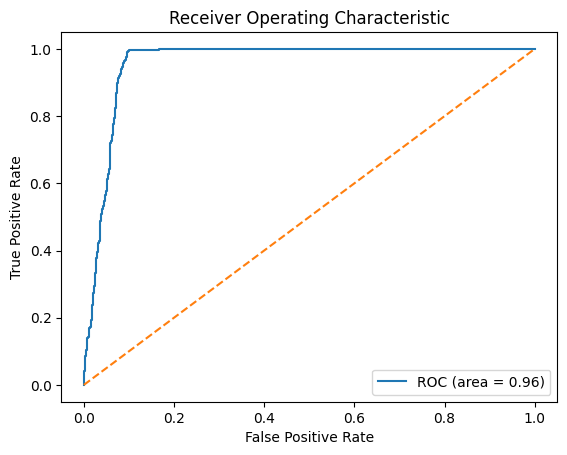

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict(test_generator, steps=len(test_generator)).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC (area = {roc_auc:.2f})')
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
